## Setup

In [1]:
import tensorflow as tf
import numpy as np
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from util import import_dataset

address = '../../data/'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
data, dictionary = import_dataset(address, file_names)

In [3]:
print(data.X_train.shape)
print(data.X_val.shape)
print(data.X_test.shape)
print(data.y_train.shape)
print(data.y_val.shape)
print(data.y_test.shape)

(25450, 128, 128, 3)
(3181, 128, 128, 3)
(3182, 128, 128, 3)
(25450,)
(3181,)
(3182,)


### Balancing dataset (optional)

In [ ]:
from util import sample_data

subreddits = ['gonewild', 'ladybonersgw', 'PrettyGirls', 'LadyBoners']
dictionary_2 = sample_data(subreddits, data, dictionary)

## Run the Model

In [15]:
from googlenet import GoogleNetMulticlass
from config import ModelConfig, TrainConfig

tf.reset_default_graph()

model_config = ModelConfig(eval_batch_size=3000, learning_rate=2e-4, output="subreddit")
train_config = TrainConfig(print_every=100, num_epochs=16, saver_address=r'../../saved_params/', \
    save_file_name = 'GoogleNet_multitask_classification_2e-4_96', lr_decay=0.96)
model = GoogleNetMulticlass(model_config)
sess = tf.Session()
model.train(data, sess, train_config)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 34.465701 seconds
Batch 200/398 of epoch 1 finished in 30.169565 seconds
Batch 300/398 of epoch 1 finished in 30.438437 seconds
Epoch 1 training finished in 124.812076 seconds
subreddit train accuracy:44.6%
nsfw train accuracy:93.6%
subreddit val accuracy:43.9%
nsfw val accuracy:93.4%
Epoch 1 evaluation finished in 23.007223 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 30.367628 seconds
Batch 200/398 of epoch 2 finished in 30.367251 seconds
Batch 300/398 of epoch 2 finished in 30.443488 seconds
Epoch 2 training finished in 120.980806 seconds
subreddit train accuracy:50.1%
nsfw train accuracy:95.1%
subreddit val accuracy:46.2%
nsfw val accuracy:94.6%
Epoch 2 evaluation finished in 22.182558 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 30.215944 seconds
Batch 200/398 of epoch 3 fi

In [21]:
model.config.learning_rate = 1e-4
train_config = TrainConfig(print_every=100, num_epochs=1, saver_address=r'../../saved_params/', \
    save_file_name = 'GoogleNet_multitask_classification_2e-4_96', lr_decay=0.96)
model.train(data, sess, train_config)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 32.625613 seconds
Batch 200/398 of epoch 1 finished in 30.392695 seconds
Batch 300/398 of epoch 1 finished in 30.498042 seconds
Epoch 1 training finished in 123.265510 seconds
subreddit train accuracy:72.2%
nsfw train accuracy:96.9%
subreddit val accuracy:50.5%
nsfw val accuracy:94.7%
Epoch 1 evaluation finished in 23.256321 seconds


PicklingError: Can't pickle <class 'multiclass_model.MulticlassModelHistory'>: it's not the same object as multiclass_model.MulticlassModelHistory

In [22]:
model.eval(data, sess, split="test")

subreddit test accuracy:51.7%
nsfw test accuracy:94.2%


(7321.395263671875, 0.51665619122465023, 0.94217484339013335)

## Load the Model

In [ ]:
from googlenet import GoogleNetMulticlass
from config import ModelConfig, TrainConfig
import pickle

# Reset Graph
tf.reset_default_graph()

# Create model instance
model_config = ModelConfig(eval_batch_size=512, learning_rate=5e-4)
model = GoogleNetMulticlass(model_config)

# Load Saved Model
sess = tf.Session()
saver = tf.train.Saver()
save_file = "../../saved_params/GoogleNet_multitask_classification"
saver.restore(sess, save_file) 
saved_history = pickle.load(open(save_file + "_modelhist", 'rb'))
model.model_history = saved_history

# Test Model Accuracy
loss_train, acc_train = model.eval(data, sess, split='train')
loss_val, acc_val = model.eval(data, sess, split = 'val')

## Plot Graph

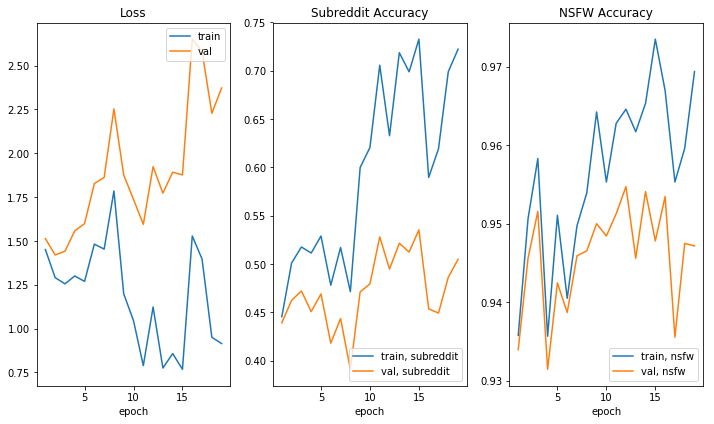

In [24]:
model.plot_loss_acc(data)

In [25]:
# Get model predictions
y_val_sbrd_pred, y_val_nsfw_pred = sess.run(model.prediction, {model.X_placeholder: data.X_val, \
                                                               model.y_sbrd_placeholder: data.y_val, \
                                                               model.y_nsfw_placeholder: data.y_val_2, \
                                                               model.is_training_placeholder:False})
y_val_sbrd_pred = np.argmax(y_val_sbrd_pred, axis = 1)
y_val_nsfw_pred = np.argmax(y_val_nsfw_pred, axis = 1)

Normalized confusion matrix


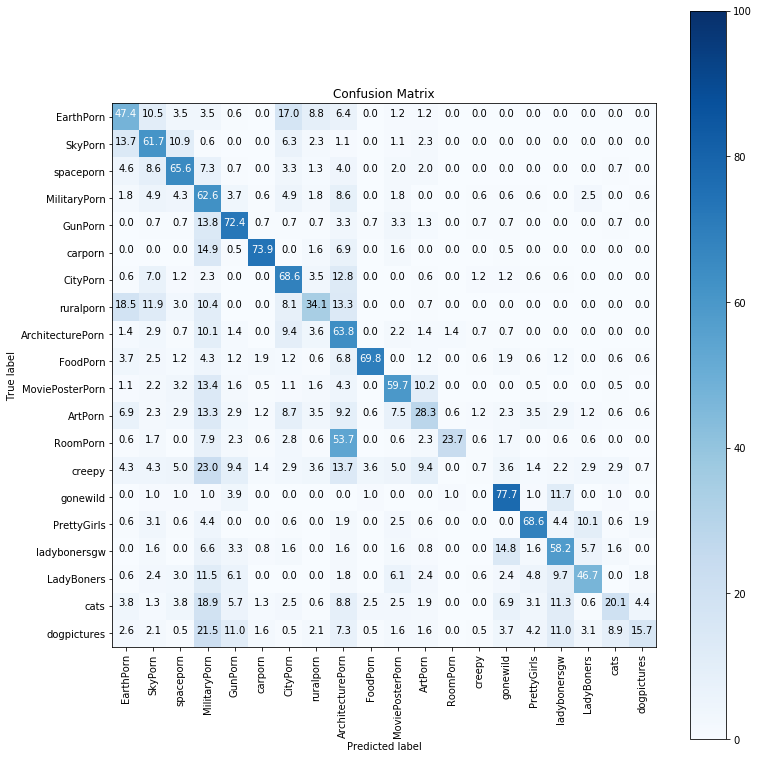

In [26]:
from util import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

classes_sbrd = sorted(dictionary, key=dictionary.get)
cm_sbrd = confusion_matrix(data.y_val, y_val_sbrd_pred)
plot_confusion_matrix(cm_sbrd, classes_sbrd, normalize=True)

Normalized confusion matrix


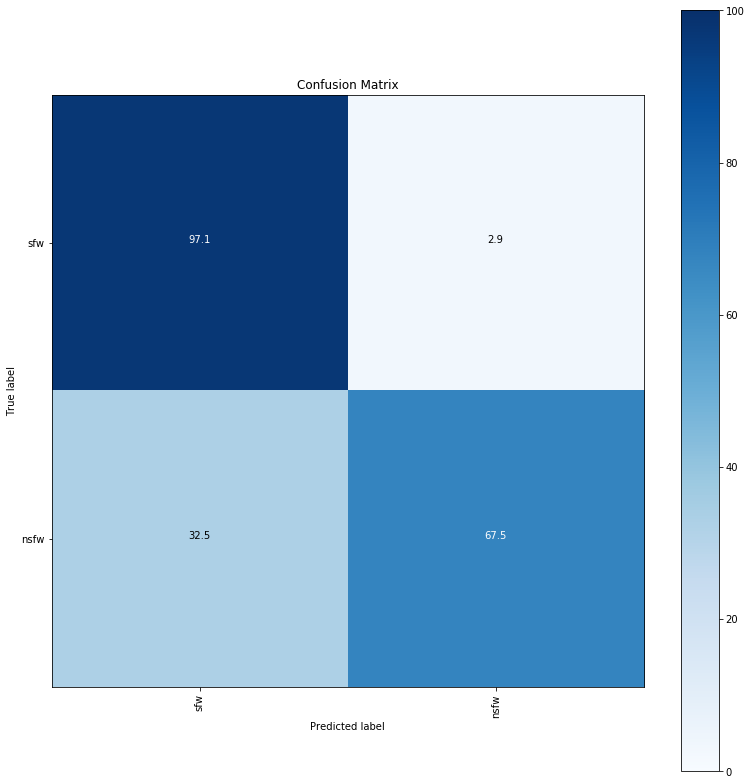

In [27]:
classes_nsfw = ["sfw", "nsfw"]
cm_nsfw = confusion_matrix(data.y_val_2, y_val_nsfw_pred)
plot_confusion_matrix(cm_nsfw, classes_nsfw, normalize=True)

## Hyperparameter Optimization

In [ ]:
import hyperopt as hpropt

def objective(args):
    model_config = ModelConfig(learning_rate=args['learning_rate'], sbrd_weight=args['sbrd_weight'], keep_prob=args['keep_prob'])
    train_config = TrainConfig(num_epochs=args['num_epochs'], lr_decay=args['lr_decay'])
    
    tf.reset_default_graph()
    model = GoogleNetMulticlass(model_config)
    
    sess = tf.Session()
    model.train(data, sess, train_config)
    cost, accuracy_sbrd, accuracy_nsfw = model.eval(data, sess, "val")
    
    saveList = {
        'accuracy_sbrd' : accuracy_sbrd,
        'accuracy_nsfw' : accuracy_nsfw,
        'cost' : cost,
        'num_epochs' : args['num_epochs'],
        'learning_rate' : args['learning_rate'],
        'lr_decay' : args['lr_decay'],
        'sbrd_weight' : args['sbrd_weight'],
        'keep_prob' : args['keep_prob']
    }    
    pickle.dump(saveList, open("../../hprOpt/" + str(accuracy_sbrd) + "_"  + str(accuracy_nsfw) + "_" + str(cost) + ".dat", "wb"))
    model.plot_loss_acc(data)
    return cost

def optimize(space, max_evals=50):
    
    space = {
        'num_epochs' : hpropt.hp.randint('num_epochs', 20),
        'learning_rate' : hpropt.hp.loguniform('learning_rate', -4, -1),
        'lr_decay' : hpropt.hp.uniform('lr_decay', 0.9, 1.0),
        'sbrd_weight' : hpropt.hp.uniform('sbrd_weight', 0.5, 1.0),
        'keep_prob' : hpropt.hp.uniform('keep_prob', 0.3, 1.0)
    }
    
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=max_evals)
    print(best)
    
    return best

In [ ]:
space = {
    'num_epochs' : 1,
    'learning_rate' : hpropt.hp.loguniform('learning_rate', -4, -1),
    'lr_decay' : hpropt.hp.uniform('lr_decay', 0.9, 1),
    'sbrd_weight' : hpropt.hp.uniform('sbrd_weight', 0.5, 1)
}
optimize(space, 2)